# Carl Zeiss Meditec Stock Analysis

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import seaborn as sb

sb.set()
%matplotlib inline

In [2]:
#API
API_KEY = "G3wE6nNEsUHBX73xYSX"

In [153]:
#Request data
url = 'https://www.quandl.com/api/v3/datasets/FSE/AFX_X.json?api_key='+API_KEY+'-&start_date=2018-01-01&end_date=2019-09-13'
afx = requests.get(url)

In [154]:
#Convert data to dict
afx_data = afx.json()

In [155]:
afx_data['dataset'].keys()

dict_keys(['id', 'dataset_code', 'database_code', 'name', 'description', 'refreshed_at', 'newest_available_date', 'oldest_available_date', 'column_names', 'frequency', 'type', 'premium', 'limit', 'transform', 'column_index', 'start_date', 'end_date', 'data', 'collapse', 'order', 'database_id'])

In [189]:
#Extra data from dict
data = pd.DataFrame(afx_data['dataset']['data'], columns=afx_data['dataset']['column_names'])

In [190]:
#Convert Date colum to DateTime
data['Date'] = pd.to_datetime(data['Date'])

#set date as index
data.set_index('Date', inplace=True)

In [191]:
data.head()

,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2019-09-13,102.2,102.3,98.10,98.9,None,130746.0,12958266.0,None,None,None
2019-09-12,101.9,102.8,100.60,101.9,None,119437.0,12145270.0,None,None,None
2019-09-11,100.7,101.7,99.00,101.0,None,171872.0,17257904.0,None,None,None
2019-09-10,105.5,105.5,99.75,100.5,None,271425.0,27466300.0,None,None,None
2019-09-09,109.1,109.7,105.70,105.7,None,86187.0,9187726.0,None,None,None


In [192]:
#select columns
data = data[['Close', 'Traded Volume']]

#re-sort data: date
data.sort_index(inplace=True)

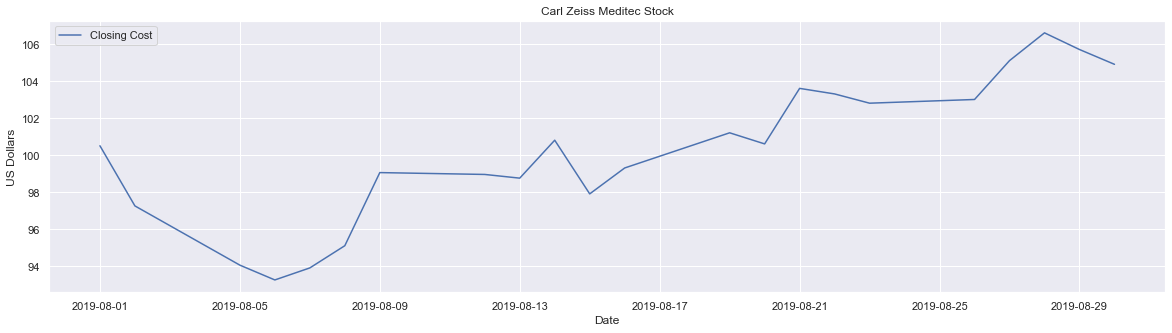

In [193]:
plt.figure(figsize=(20,5))
plt.plot(data['Close']['2019-08-01':'2019-08-30'], label= 'Closing Cost')
plt.xlabel('Date')
plt.ylabel('US Dollars')
plt.title("Carl Zeiss Meditec Stock")
plt.legend()

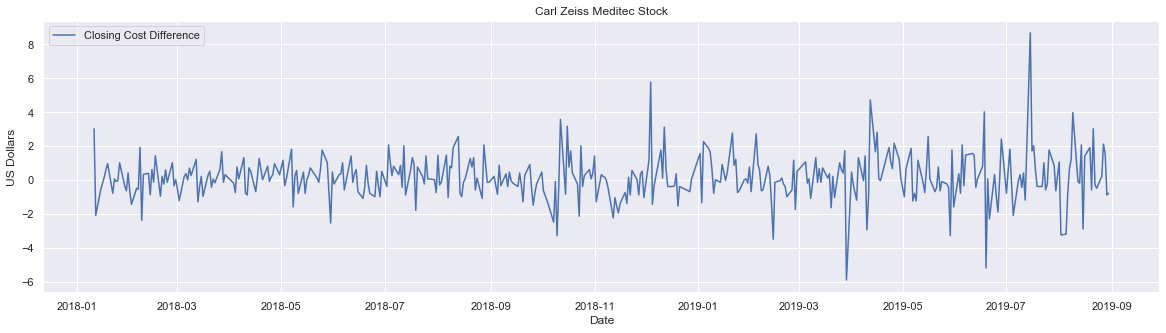

In [194]:
plt.figure(figsize=(20,5))
plt.plot(data['Close'][:'2019-08-30'].diff(), label= 'Closing Cost Difference')
plt.xlabel('Date')
plt.ylabel('US Dollars')
plt.title("Carl Zeiss Meditec Stock")
plt.legend()

In [195]:
#price change percent
#data['1d_close_pct'] = data['Close'].pct_change(1)

#shift data
data['1d_future_close'] = data['Close'].shift(-1)
data['1d_close_future_pct'] = data['1d_future_close'].pct_change(1)
data['1d_close_pct'] = data['Close'].pct_change(1)
data['1d_tvol_pct'] = data['Traded Volume'].pct_change()


In [37]:
def RSI(series, period):
    change = series.diff()
    gain = change.mask(change<0, 0)
    loss = change.mask(change>0, 0)
    avg_gain = gain.ewm(com= period-1, min_periods= period).mean()
    avg_loss = loss.ewm(com= period-1, min_periods= period).mean()
    rs = abs(avg_gain/avg_loss)
    return (100 - (100/(1+rs)))

In [196]:
# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
# Add rsi and moving average to the feature name list
for n in [14, 30, 50, 200]:
    data['ma' + str(n)] = data['Close'].rolling(window=5).mean()
    data['rsi' + str(n)] = RSI(data['Close'], n)


In [197]:
data.dropna(inplace=True)

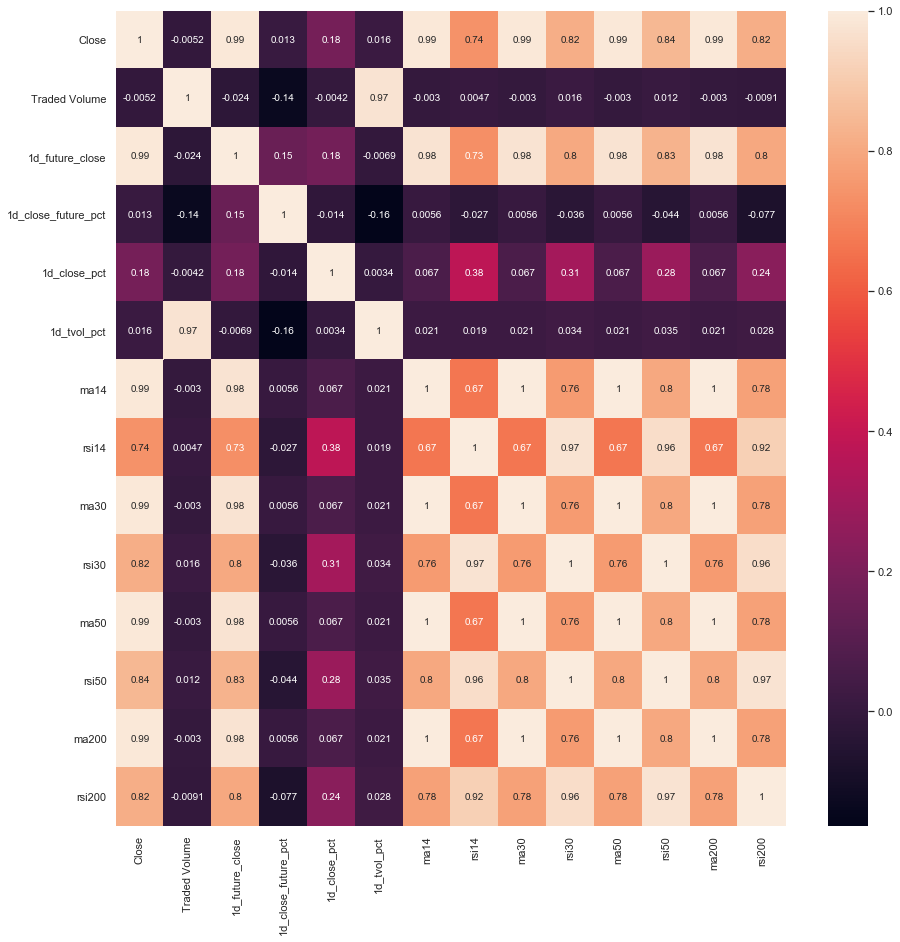

In [198]:
plt.figure(figsize=(15,15))
sb.heatmap(data.corr(), annot=True)

In [215]:
features = ['Close', 'ma50']

In [216]:
# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
X = data[features]
y = data['1d_future_close']


In [515]:
data['Close'] = np.log(data['Close'])
data['1d_future_close'] = np.log(data['1d_future_close'] )
data['ma5'] = np.log(data['ma5'])
data['rsi5'] = np.log(data['rsi5'])

C:\Users\sirro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [223]:
data2 = data[features + ['1d_future_close']]

In [225]:
data2.tail()

,Close,ma50,1d_future_close
Date,,,
2019-09-06,108.7,107.42,105.7
2019-09-09,105.7,107.22,100.5
2019-09-10,100.5,105.92,101.0
2019-09-11,101.0,104.46,101.9
2019-09-12,101.9,103.56,98.9


In [210]:
export_csv = data2.to_csv('CarlMeditecStockfew.csv')

In [217]:
data = data.dropna()

In [226]:
df_norm = (data2 - data2.mean()) / (data2.max() - data2.min())
df_norm.head()

,Close,ma50,1d_future_close
Date,,,
2018-10-26,-0.280111,-0.296026,-0.269010
2018-10-29,-0.267532,-0.294717,-0.267962
2018-10-30,-0.266484,-0.283809,-0.259576
2018-10-31,-0.258098,-0.279883,-0.230226
2018-11-01,-0.228748,-0.268103,-0.257480


In [563]:
export_csv = df_norm['2017-01-10':].to_csv('CarlMeditecStock4.csv')

In [228]:
X = data2[['Close', 'ma50']]
y = data2['1d_future_close']

In [229]:
train_size = round(0.80 * y.shape[0])

X_train = X[:train_size].to_numpy()
y_train = y[:train_size].to_numpy()
X_test = X[train_size:].to_numpy()
y_test = y[train_size:].to_numpy()


In [230]:
def R2(y, y_hat):
    return (1 - (sum((y-y_hat)**2)/(sum((y-np.mean(y))**2))))

In [378]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

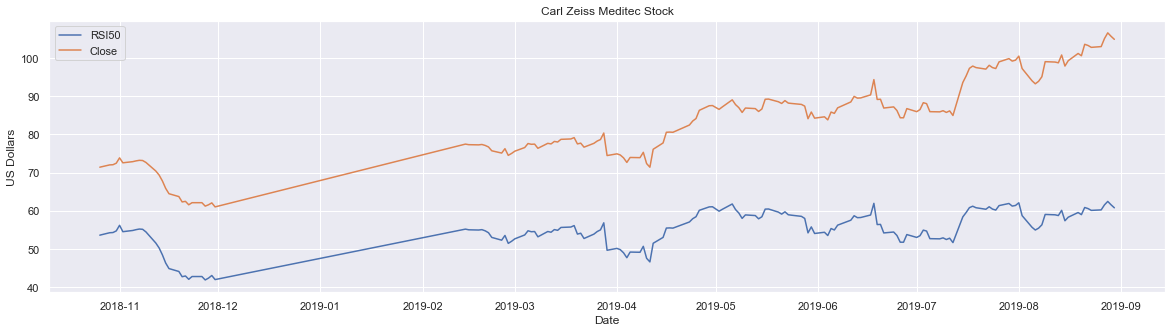

In [206]:
plt.figure(figsize=(20,5))
plt.plot(data['rsi50'][:'2019-08-30'], label= 'RSI50')
plt.plot(data['Close'][:'2019-08-30'], label= 'Close')
plt.xlabel('Date')
plt.ylabel('US Dollars')
plt.title("Carl Zeiss Meditec Stock")
plt.legend()

In [231]:
class LinearRegression():
    def fit(self, X, y, eta= 0.001, epochs= 1000):
        self.X = X
        self.Y = y
        self.costs = []
        D = X.ndim
        if D == 1:
            denom = self.X.dot(self.X) - self.X.mean() * self.X.sum()
            self.a = (self.X.dot(self.Y) - self.Y.mean()*X.sum()) / denom
            self.b = (self.Y.mean() * self.X.dot(X) - self.X.mean() * self.X.dot(self.Y)) / denom
    
        else:
            self.w = np.random.randn(self.X.shape[1]) / np.sqrt(self.X.shape[1])

            for t in range(epochs):
                y_hat = self.X.dot(self.w)
                delta = y_hat - self.Y
                self.w = self.w - eta*self.X.T.dot(delta)
                mse = delta.dot(delta) / self.X.shape[0]
                self.costs.append(mse)
    
    def predict(self, X):
        D = X.ndim
        if D == 1:
            y_hat = self.a*X + self.b
        else:
            y_hat = X.dot(self.w)
        
        return y_hat

In [232]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

C:\Users\sirro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract


In [48]:
y_hat = lin_reg(X_test, y_test)

TypeError: 'LinearRegression' object is not callable

In [220]:
class KNNRegressor():
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon = 1e-2):
        N, D = X.shape
        y_hat = np.empty(N)
    
        for i in range(N):
            sq_dist = np.sum((X - self.X[i])**2, axis = 1) #(self.X - X[1])  self.X NxD difference row wise results in an N dim array
            idx = np.argsort(sq_dist)[:K] #returns the idx of K in ascending order
            #gamma = 1 / (np.sqrt(sq_dist[idx]) + epsilon)
            gamma = np.exp(-sq_dist[idx])/np.exp(-sq_dist[idx]).sum()
            #y_hat[i] = gamma.dot(self.y[idx])/gamma.sum()
            #y_hat[i] = np.bincount(self.y[idx], weights = gamma).argmax()
            y_hat[i] = gamma.dot(self.y[idx])
        
        return y_hat

In [221]:
knn = KNNRegressor()
knn.fit(X_train, y_train)

In [222]:
pred_close = knn.predict(X_test, 5)

C:\Users\sirro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [211]:
predictions = pd.read_csv('predictions.csv')

In [212]:
predictions.head()

,Unnamed: 0,Close,ma50,rsi50,y_test,pred_close
0,139,99.00,97.79,61.336737,99.85,97.503689
1,140,99.85,98.34,61.891032,99.20,97.497400
2,141,99.20,98.56,61.206321,99.45,97.506777
3,142,99.45,98.95,61.374031,100.50,97.498512
4,143,100.50,99.60,62.076664,97.25,97.498479


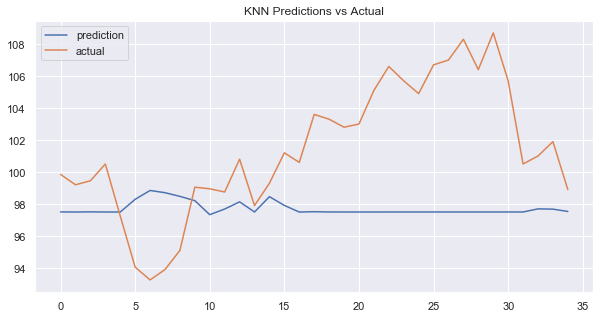

In [214]:
plt.figure(figsize= (10,5))
plt.plot(predictions['pred_close'], label='prediction')
plt.plot(predictions['y_test'], label='actual')
plt.title('KNN Predictions vs Actual')
plt.legend()